In [5]:
import cv2
import torch
import numpy as np
from PIL import Image

In [3]:
image_path = "/home/chuongh/vm2m/data/VIPSeg/out/fgr/2_bdIa52B2QGI/00002207.jpg"
mask_path = "/home/chuongh/vm2m/data/VIPSeg/out/mask/2_bdIa52B2QGI/00002207/00.png"
matte_path = "/home/chuongh/vm2m/data/VIPSeg/out/pha_vid_0911_from-seg/2_bdIa52B2QGI/00002207/00.png"

In [6]:
image = Image.open(image_path).convert("RGB")
image = np.array(image)
# Normalize image
image = image / 255.0
image = torch.from_numpy(image).float()
image = image.permute(2, 0, 1)
image = image.unsqueeze(0)
image = image - torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
image = image / torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

In [11]:
mask = Image.open(mask_path).convert("L")
mask = np.array(mask)
mask = torch.from_numpy(mask).float()
mask = mask.unsqueeze(0) / 255.0

In [12]:
matte = Image.open(matte_path).convert("L")
matte = np.array(matte)
matte = torch.from_numpy(matte).float()
matte = matte.unsqueeze(0) / 255.0

In [18]:
# Motion blur
import albumentations as A
motion_aug = A.MotionBlur(p=1.0, blur_limit=(3,49))


In [45]:
inp = torch.cat([image[0].permute(1, 2, 0), mask[0, :, :, None], matte[0, :, :, None]], dim=2) # H x W x 5
# inp = inp.numpy()
# aug_res = motion_aug(image=inp)["image"]

In [41]:
kernel = motion_aug.get_params()["kernel"]

In [51]:
torch.from_numpy(kernel[None, None]).shape

torch.Size([1, 1, 27, 27])

In [52]:
from torch.nn import functional as F
out_kernel = torch.from_numpy(kernel[None, None])
out_kernel = out_kernel.repeat(5, 1, 1, 1)
F.conv2d(inp.permute(2, 0, 1)[None], out_kernel, stride=1, padding=kernel.shape[0]//2, groups=5).shape

torch.Size([1, 5, 1080, 1920])

In [53]:
inp.shape

torch.Size([1080, 1920, 5])

In [22]:
aug_res.shape

(1080, 1920, 5)

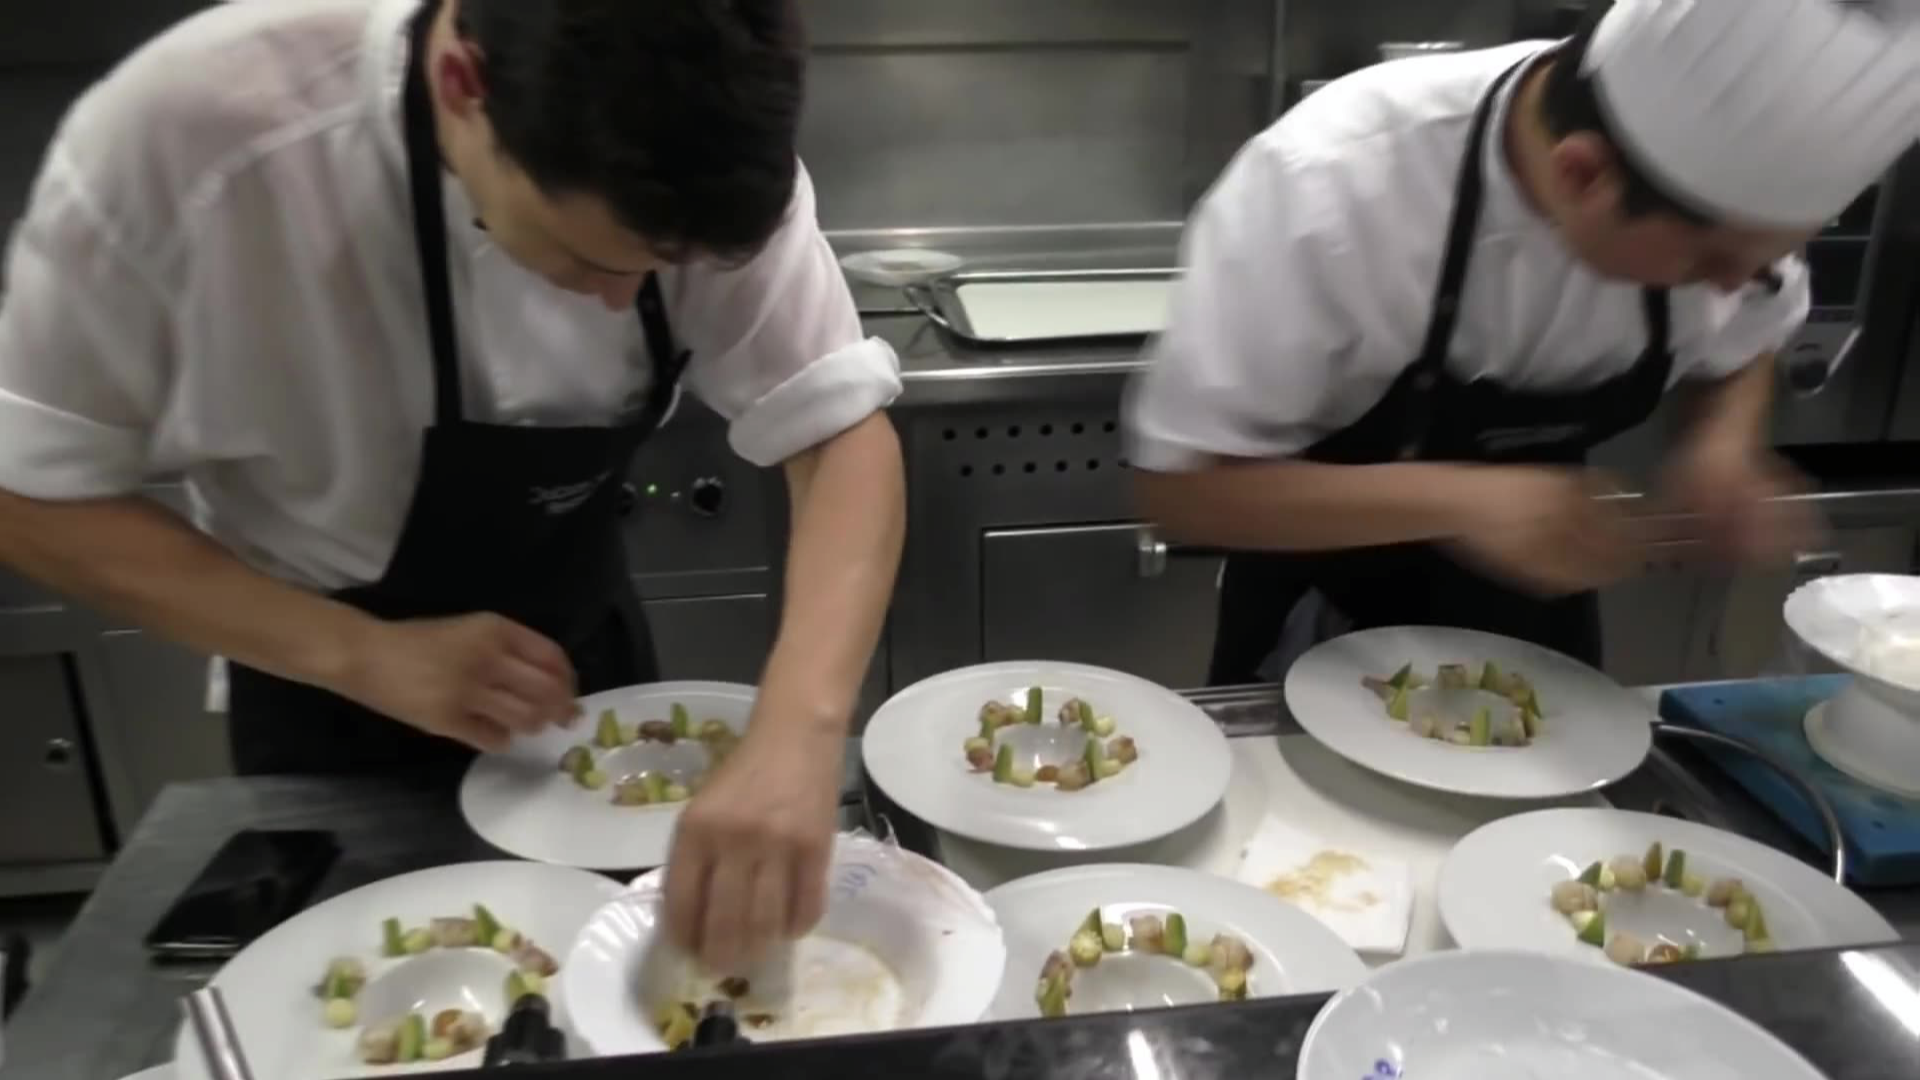

In [24]:
# Vis image
aug_image = aug_res[:, :, :3]

# De-normalize image
aug_image = aug_image * np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
aug_image = aug_image + np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
aug_image = aug_image * 255.0
aug_image = np.clip(aug_image, 0, 255).astype(np.uint8)

Image.fromarray(aug_image)

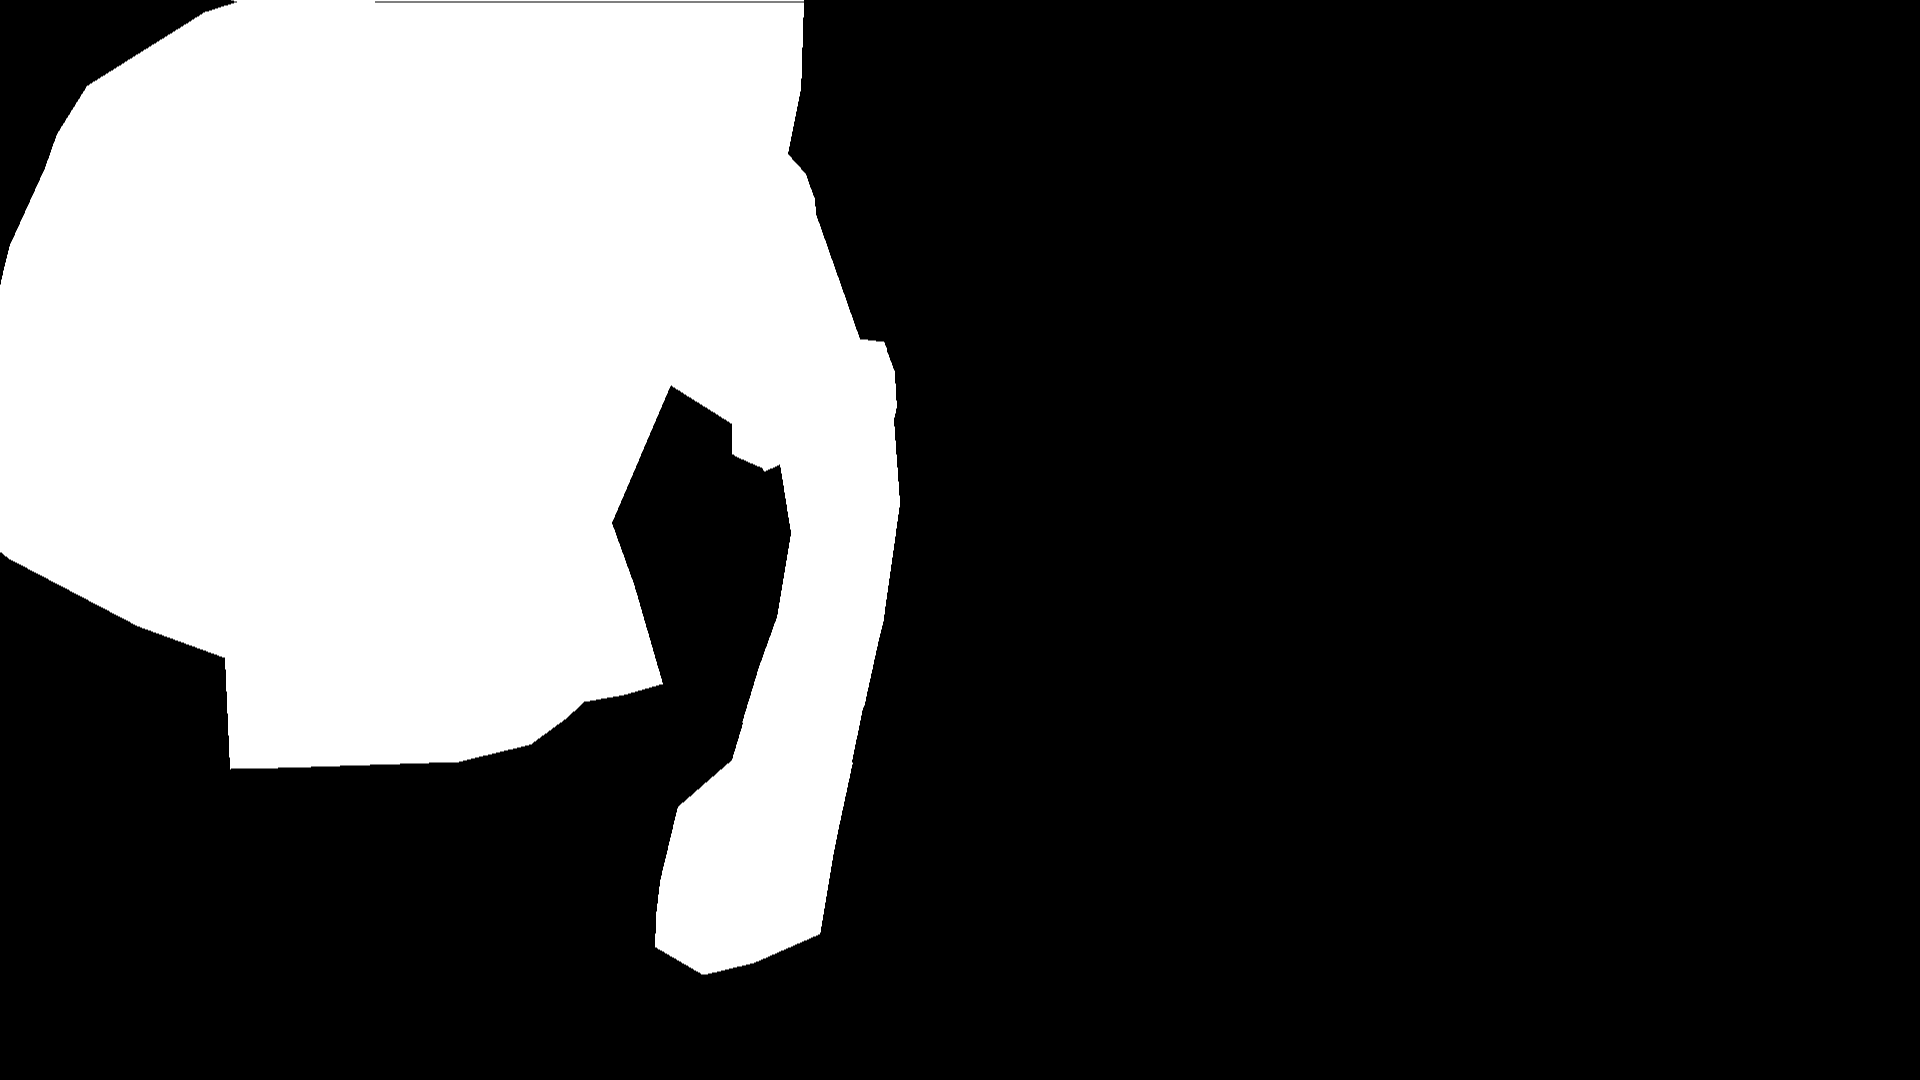

In [32]:
# Vis mask
aug_mask = aug_res[:, :, 3]
aug_mask = np.clip(aug_mask * 255.0, 0, 255).astype(np.uint8)

Image.fromarray(aug_mask)